In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cf
import regionmask
from Data.utils.taylor import *
import cartopy.feature as cf
import matplotlib.colors as colors
from cmcrameri import cm

In [3]:
shp_pan = gpd.read_file(r'Data\shapefiles\panamz.geojson')
datasets = ['cru', 'gpcc', 'chirps','imerg', 'terra', 'era_land', 'jra55','merra2']
datasets_names = ['CRU', 'GPCC', 'CHIRPS','IMERG-V6', 'TerraClimate', 'ERA5-Land', 'JRA55','MERRA2']
regions = gpd.read_file(r'Data\shapefiles\ANA_amz.geojson', driver='GeoJSON')
regions_mask = regionmask.from_geopandas(regions, names='Region')
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 18})
regions_list = ['Western', 'Northern', 'Southern', 'Eastern']
regions_replace = { 0:'Southern', 1:'Eastern',2:'Western', 3:'Northern'}
wong = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#999999']
wong_b = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#000000']
hue_order = datasets_names.copy()
hue_order.append('Stations')
legend_elements = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong[i], markersize=12) for i in range(len(wong))]
legend_elements_b = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong_b[i], markersize=12) for i in range(len(wong_b))]


In [17]:
varss = ['dsl', 'ent', 'mcwd']
vars_names = ['DSL', 'RE', 'MCWD']
letters_ts = ['a)', 'b)', 'c)', 'd)']

# clim

In [41]:
ds_dict = {}
for i, dataset in enumerate(datasets):
    list_var = []
    for var in varss:
        folder_metric = rf'Data\Datasets\amz\{var}\clim'
        dss = xr.open_dataset(os.path.join(folder_metric, dataset + '.nc'))
        list_var.append(dss)
    ds = xr.merge(list_var)
    #create mask from regions
    mask = regions_mask.mask(ds, lon_name='lon', lat_name='lat')
    ds['Region'] = mask
    ds_dict[datasets_names[i]] = ds
    

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [94]:
#open stations
dss_dsl = gpd.read_file(rf'Data\Datasets\amz\dsl\stations.geojson')
dss_ent = gpd.read_file(rf'Data\Datasets\amz\ent\stations.geojson')
dss_mcwd = gpd.read_file(rf'Data\Datasets\amz\mcwd\stations.geojson')
#merge the 3 in Code
dss = dss_dsl.merge(dss_ent, on='Code')
dss = dss.merge(dss_mcwd, on='Code')
stations = dss[['Code','Region', 'geometry', 'dsl', 'ent', 'mcwd']]
#to gpd
stations = gpd.GeoDataFrame(stations, geometry='geometry')


In [118]:
import cmocean

extent=[-81, -42, -20, 11]
proj=ccrs.Mercator()
vmin = [0, 0, -400]
vmax = [8, 1, 0.01]
levels = [9, 11, 9]
cmap = [mpl.cm.cividis, mpl.cm.inferno, cm.lajolla]
extend_cbar = ['max', 'max', 'min']
var = ['dsl', 'ent', 'mcwd']
label_cbar = ['Dry Season \n Length (month)', 'Relative Entropy', 'Maximum Cumulative \n Water Deficit (mm)']


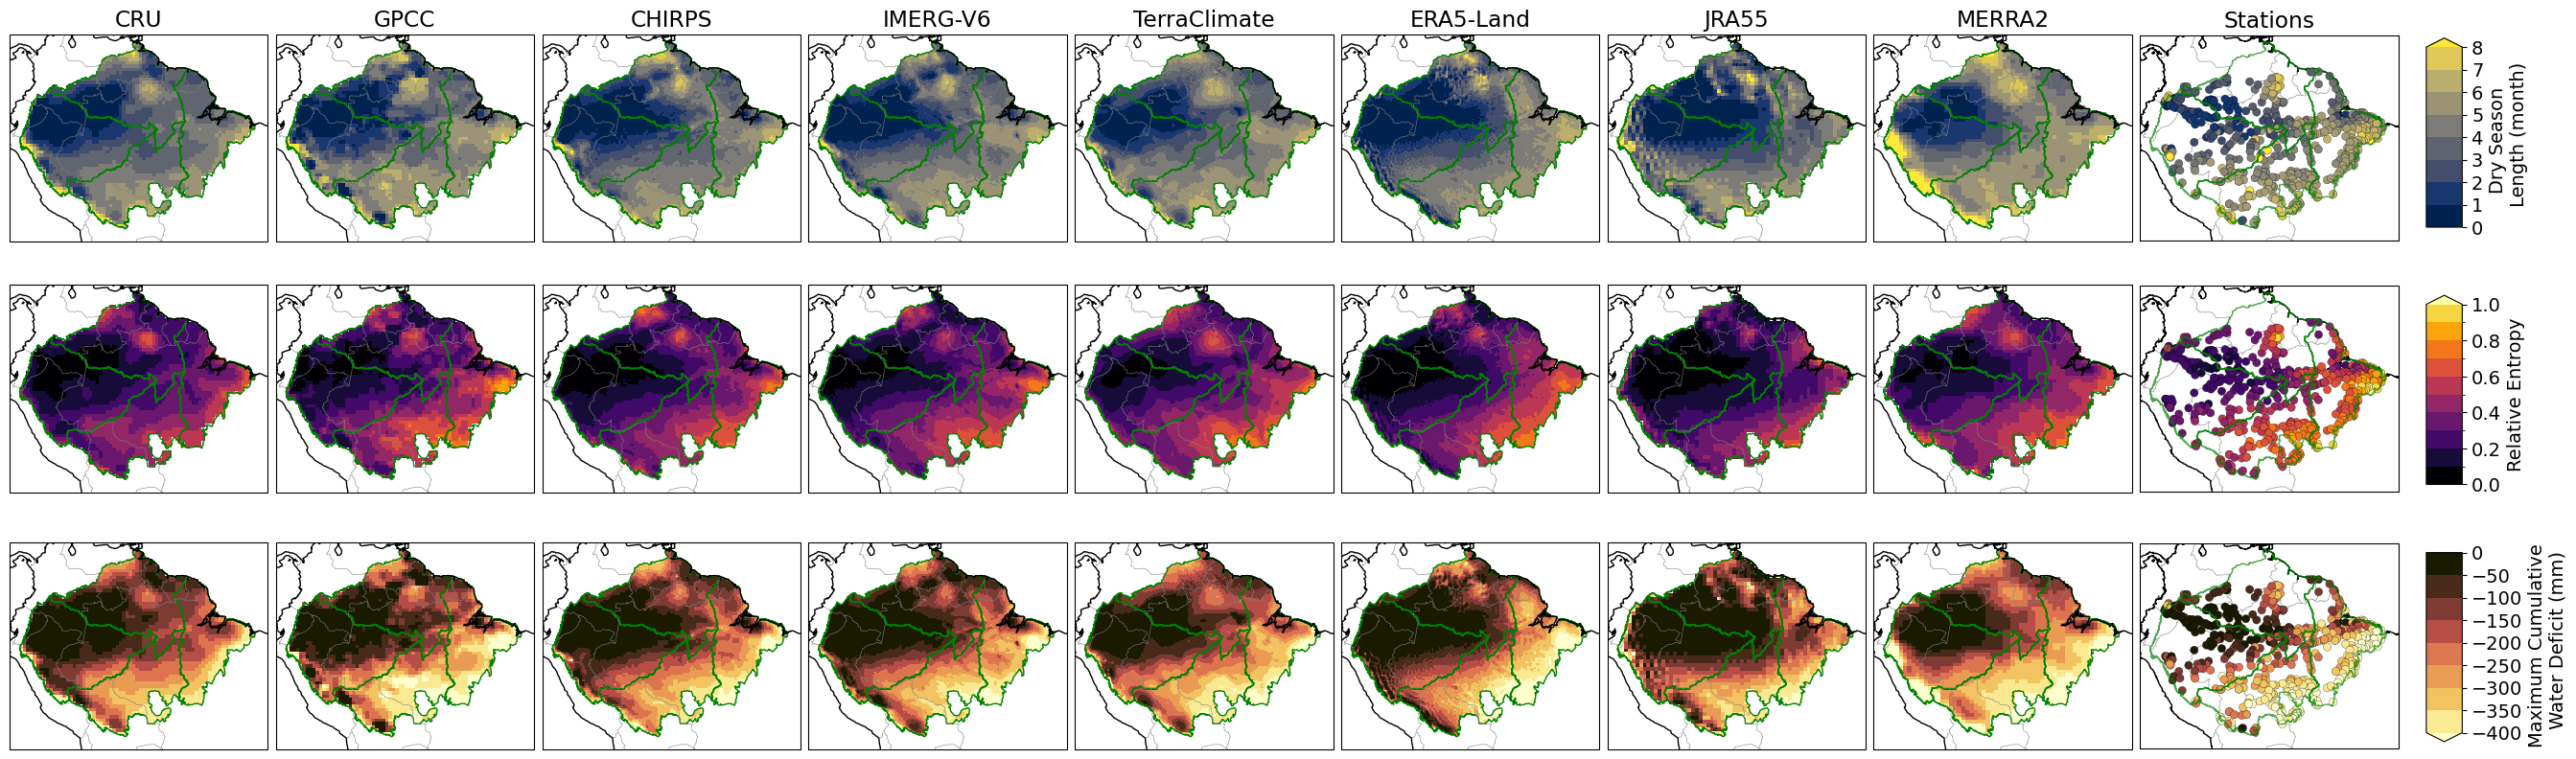

In [122]:
fig = plt.figure(figsize=(25, 8), constrained_layout=True)
subfigs = fig.subfigures(3, 1)
for v, var in enumerate(varss):
    axes = subfigs[v].subplots(1, len(datasets)+1, subplot_kw={'projection': proj})
    bounds = np.linspace(vmin[v], vmax[v], levels[v])
    norm = colors.BoundaryNorm(bounds, cmap[v].N, extend=extend_cbar[v])
    sm = plt.cm.ScalarMappable(cmap=cmap[v], norm=norm)
    sm._A = []
    #now a vertical cbar in the right of subfigs
    cax = subfigs[v].add_axes([1.01, 0.12, 0.015, 0.75])
    subfigs[v].colorbar(sm, cax=cax, orientation='vertical', label=label_cbar[v])
    for i, dataset in enumerate(datasets_names):
        ax = axes[i]
        ds = ds_dict[dataset][var]
        im = ds.plot(ax=ax, cmap=cmap[v], vmin=vmin[v], vmax=vmax[v], add_colorbar=False, transform=ccrs.PlateCarree(), levels=levels[v], extend=extend_cbar[v])
        ax.add_geometries(regions.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='green', linewidth=1)
        ax.add_feature(cf.BORDERS, edgecolor='grey', linewidth=0.4)
        axes[i].set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_title('')
        if v == 0:
            ax.set_title(dataset)
    

    ax_stat = axes[-1]
    ax_stat.coastlines(transform=ccrs.PlateCarree())
    ax_stat.add_geometries(cf.BORDERS.geometries(), crs=proj, linewidth=0.4, edgecolor='grey', facecolor='none', zorder=0)
    ax_stat.add_geometries(cf.COASTLINE.geometries(), crs=proj, linewidth=1, edgecolor='black', facecolor='none', zorder=0)
    stations.plot(ax=ax_stat, column=var, cmap=cmap[v], scheme="User_Defined",
                  classification_kwds=dict(bins=bounds), linewidth=0.2, edgecolor='black')
    ax_stat.set_title('')
    if v == 0:          
        ax_stat.set_title('Stations')
    regions.plot(ax=ax_stat, facecolor='none', edgecolor='green', linewidth=1, alpha=0.7)
    ax_stat.set_xlim(extent[0], extent[1])
    ax_stat.set_ylim(extent[2], extent[3])    


In [125]:
#create a df with all ds in ds_dict
df = pd.DataFrame()
for name in datasets_names:
    dff =  ds_dict[name].to_dataframe().dropna().reset_index(drop=True)
    dff['Dataset'] = name
    df = df.append(dff)
df = df[['dsl', 'ent', 'mcwd', 'Region', 'Dataset']]
df['Region'] = df['Region'].replace(regions_replace)
df_stat = stations[['dsl', 'ent', 'mcwd', 'Region']].copy()
df_stat['Dataset'] = 'Stations'
df = df.append(df_stat)

C:\Users\luisg\AppData\Local\Temp\ipykernel_23820\667494703.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_23820\667494703.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_23820\667494703.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_23820\667494703.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_23820\667494703.py:6: FutureWarning: The frame.append method is deprecat

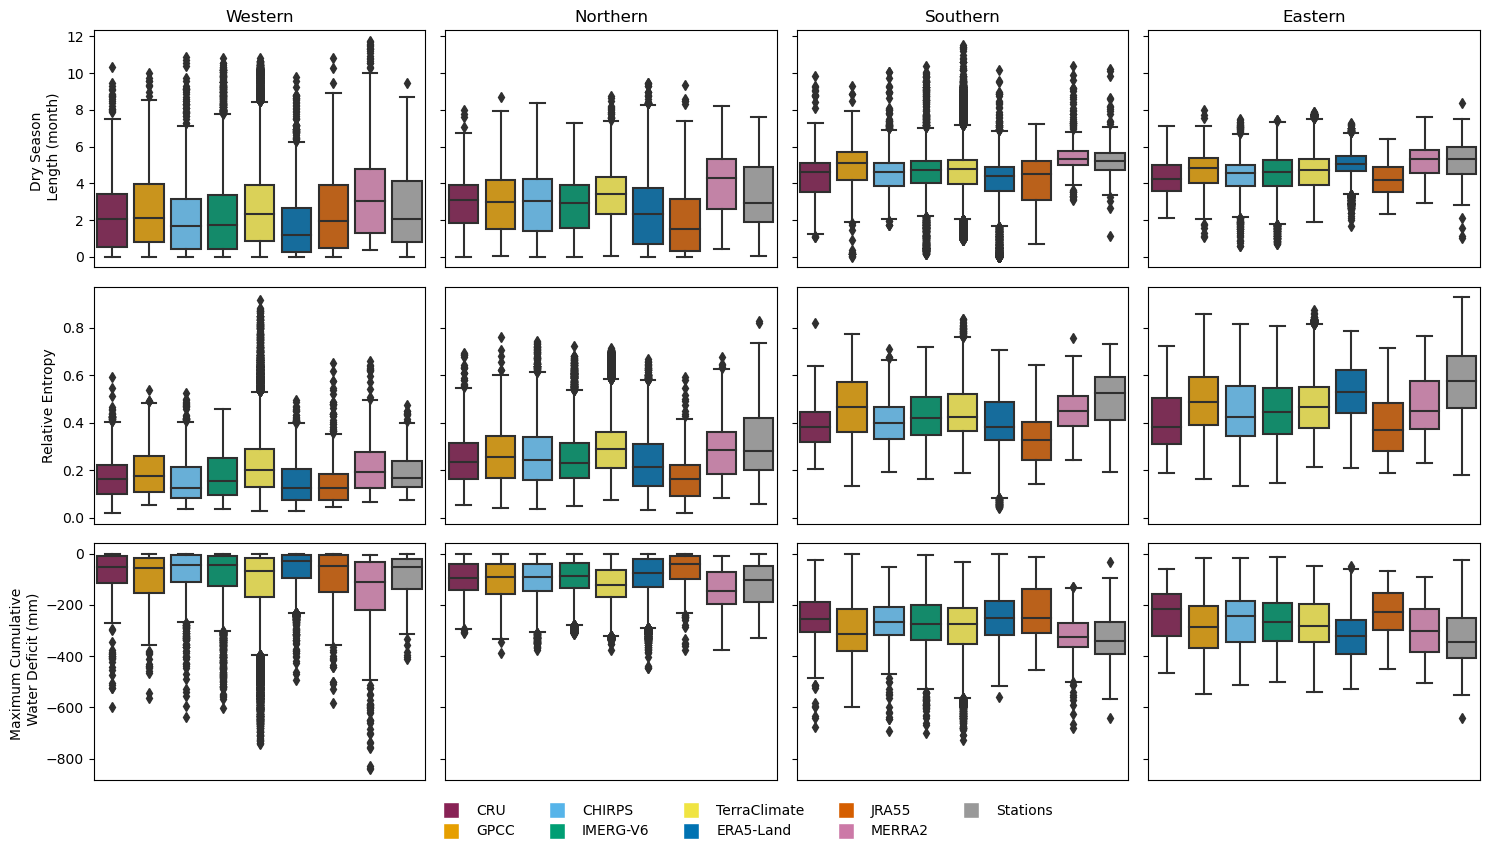

In [145]:
#boxplot of df for each var and each region
fig, axes = plt.subplots(3, 4, figsize=(15, 8), sharex=True, sharey='row')

for v, var in enumerate(varss):
    for r, region in enumerate(regions_list):
        ax = axes[v, r]
        sns.boxplot(x='Dataset', y=var, data=df[df['Region'] == region], ax=ax, palette=wong)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
        if v == 0:
            ax.set_title(region)
        if r == 0:
            ax.set_ylabel(label_cbar[v])

#add legend
fig.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.07), loc='lower center', ncol=5, frameon=False)

plt.tight_layout()

# taylor

In [8]:
#open df corrs and append
list_dfs = []
for var in varss:
    df = pd.read_csv(rf'Data\Datasets\amz\{var}\corr.csv', index_col=0)
    list_dfs.append(df)

df_taylor = pd.concat(list_dfs)


In [24]:
marker_list = ['*','o', '^' ]
marker_legend = [Line2D([0], [0],  marker='*', color='w', label='DSL', markerfacecolor='black', markersize=12),
                  Line2D([0], [0],  marker='o', color='w', label='RE', markerfacecolor='black', markersize=12),
                  Line2D([0], [0],  marker='^', color='w', label='MCWD', markerfacecolor='black', markersize=12)]
marker_legend = marker_legend +  legend_elements_b

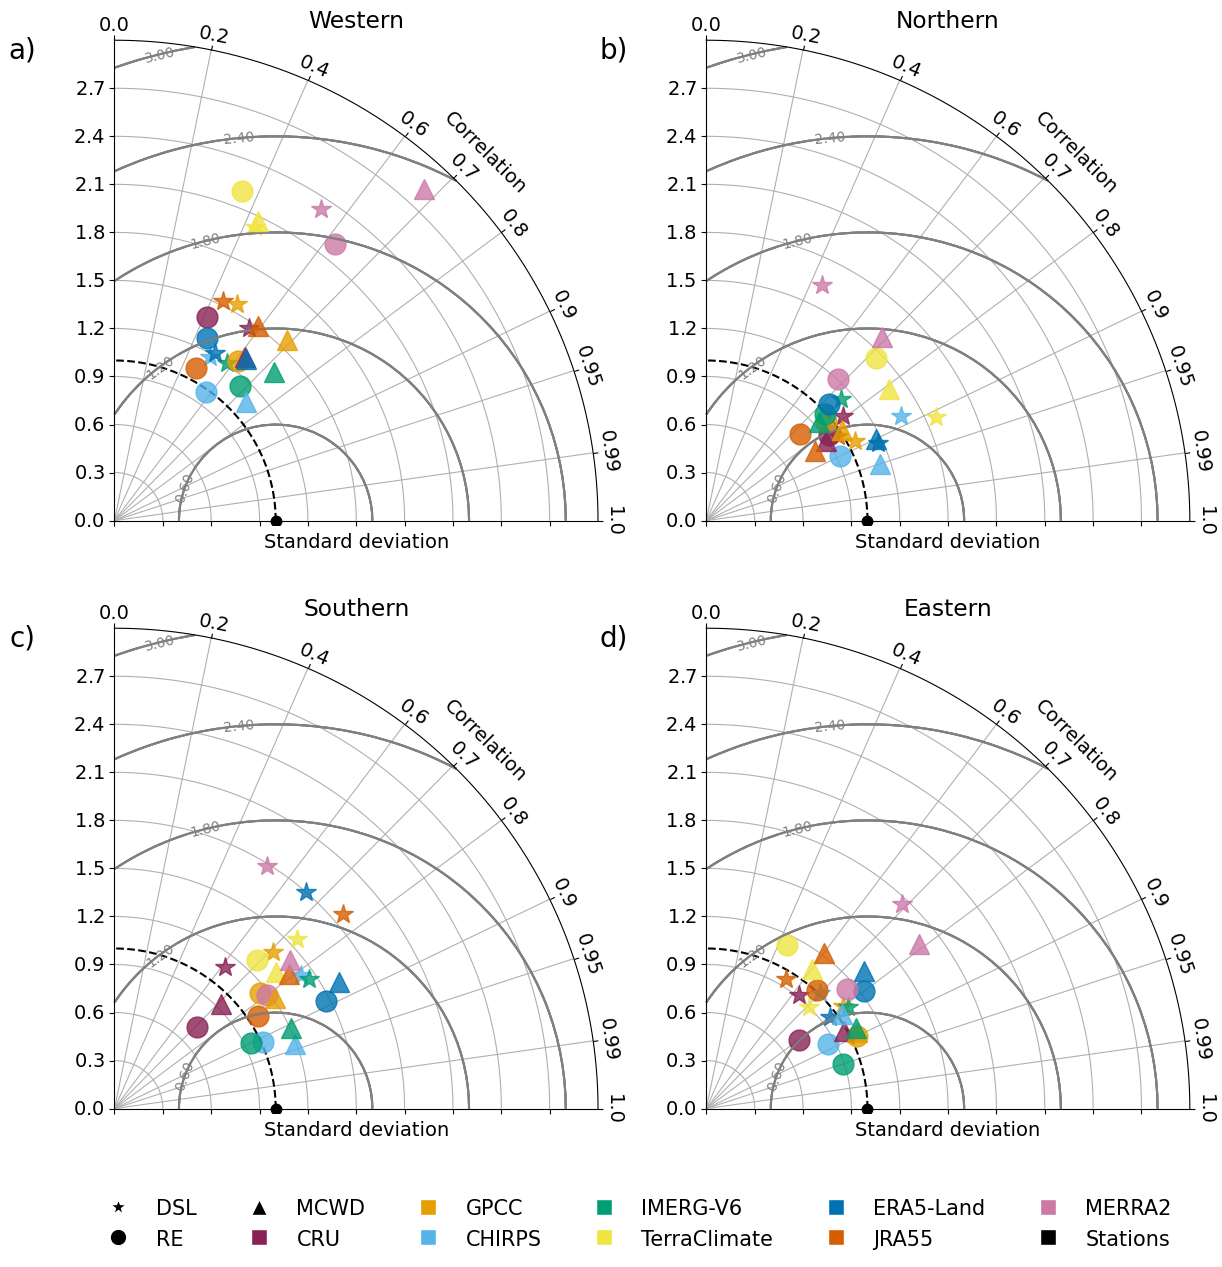

In [25]:
# Create a figure and a gridspec layout
fig = plt.figure(figsize=(14, 14))
plt.rcParams.update({'font.size': 14})
mss = 15
for i, region in enumerate(regions_list):
    dia = TaylorDiagram(1, fig=fig, label='Stations', extend=False, rect=int('22'+str(i+1)),srange=(0, 3),mss =mss)

# Create a figure and a gridspec layout
    for k, varr in enumerate(vars_names):
        df_taylor_var = df_taylor[df_taylor['metric'] == varr]
        df_reg = df_taylor_var[df_taylor_var.Region == region]
        # Add samples to Taylor diagram
        contours = dia.add_contours(colors='0.5')
        for j, name in enumerate(datasets_names):
            df_set = df_reg[df_reg['Dataset'] == name]
            std = df_set['sd'].values[0]
            corr = df_set['corr'].values[0]
            dia.add_sample(std, corr, marker=marker_list[k], ms=mss, ls='', mfc=wong_b[j], mec=wong_b[j], label=name, alpha=0.8)

    
    dia.add_grid()                                  # Add grid
    dia._ax.axis[:].major_ticks.set_tick_out(True)
    dia._ax.axis['left'].toggle(ticklabels=False)
    dia._ax.axis['left'].label.set_text("Standard deviation")
    dia._ax.set_title(region) 
    dia._ax.text(-0.15,1,  letters_ts[i], transform=dia._ax.transAxes,  fontsize=20, va='top', ha='right')    

    # Put ticks outward
#legend in the middle outside of the plot
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

fig.legend(handles=marker_legend, bbox_to_anchor=(0.5, 0), loc='lower center', ncol=6, frameon=False, fontsize=15)
#legend in the middle outside of the plot
#plt.tight_layout()

# tabela

In [29]:
#open df corrs and append
list_dfs = []
for var in varss:
    df = pd.read_csv(rf'Data\Datasets\amz\{var}\pixel_best.csv', index_col=0)
    list_dfs.append(df)

df_best = pd.concat(list_dfs).drop(columns=['index'])

In [37]:
df_best.set_index(['Region', 'metric'])

,,corr,kge,nse,rmse,mae,mape
Region,metric,,,,,,
Eastern,DSL,CHIRPS,IMERG-V6,IMERG-V6,GPCC,GPCC,CHIRPS
Northern,DSL,CHIRPS,CHIRPS,CHIRPS,CHIRPS,CHIRPS,JRA55
Southern,DSL,CHIRPS,CHIRPS,IMERG-V6,IMERG-V6,IMERG-V6,JRA55
Western,DSL,GPCC,IMERG-V6,IMERG-V6,IMERG-V6,IMERG-V6,CHIRPS
Eastern,RE,CHIRPS,CHIRPS,IMERG-V6,GPCC,GPCC,GPCC
Northern,RE,CHIRPS,CHIRPS,CHIRPS,GPCC,GPCC,CHIRPS
Southern,RE,CHIRPS,CHIRPS,IMERG-V6,IMERG-V6,IMERG-V6,IMERG-V6
Western,RE,CHIRPS,GPCC,IMERG-V6,GPCC,GPCC,IMERG-V6
Eastern,MCWD,CHIRPS,CHIRPS,GPCC,GPCC,GPCC,CHIRPS
